#Ensaio sobre analisador supervisionado em partidas de Counter Strike: Global Offensive 


*   Guilherme Martiniano De Oliveira
guizera11@usp.br

*   
Renan Gomes Carneiro de Freitas
renangcfreitas@usp.br




##Importação de Bibliotecas

In [ ]:
from io import open
import requests

In [ ]:
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
!pip install -U scikit-learn

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedShuffleSplit, ParameterGrid
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from sklearn import metrics

##Extração de Dados do Arquivo

In [ ]:
#Path for the data file (external link)
#https://www.kaggle.com/christianlillelund/csgo-round-winner-classification
#https://github.com/Guimol/RedesNeuraisDataBase

path = 'https://raw.githubusercontent.com/Guimol/RedesNeuraisDataBase/main/csgo_round_snapshots.csv'

#Creating local file for the corpus
r = requests.get(path, allow_redirects=True)
open('data', 'wb').write(r.content)

#Trabalhando com o corpus
data = open('data', "r", encoding = "utf-8")

texto = data.read()

##Criação de Seed de controle

In [ ]:
SET_SEED = 420
np.random.seed(SET_SEED)

##Pré-Processamento dos Dados

In [ ]:
df = pd.read_csv('data')

###Remoção de Caso Absurdo (Outliers)

In [ ]:
#eliminar linha com t_players_alive = 6
indexToRemove = df[df['t_players_alive'] == 6].index.values[0]
df_novo = df.drop(indexToRemove)
#trazendo cada linha 1 index para cima
df_novo = df_novo.reset_index(drop=True)

###Separação em Dados Categoricos

In [ ]:
colunas = ['map']

df_categorical = pd.DataFrame(df_novo[colunas])

encoder = OneHotEncoder()

df_OneHotEncoder = encoder.fit_transform(df_categorical).toarray()
df_OneHotEncoder = pd.DataFrame(df_OneHotEncoder)

In [ ]:
nome_mapas = list(encoder.categories_[0])

dict_nomes = {}
for num in df_OneHotEncoder.columns:
  dict_nomes[num] = nome_mapas[num]

df_OneHotEncoder = df_OneHotEncoder.rename(columns=dict_nomes)

###Transformação em Dados Binários

In [ ]:
colunas = ['bomb_planted', 'round_winner']

df_binario = df_novo[colunas]
df_binario = df_binario.replace(False, 0)
df_binario = df_binario.replace(True, 1)
df_binario = df_binario.replace('CT', 0)
df_binario = df_binario.replace('T', 1)

In [ ]:
df_pre_divisao = pd.concat([df_OneHotEncoder, df_novo[['time_left', 'ct_score', 't_score', 'ct_health', 't_health', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive', 'ct_total_util', 'tr_total_util']], df_binario], axis=1)

### Separação dos Dados de Teste e Treino

In [ ]:
df_pre_divisao['round_winner'].value_counts() / len(df_pre_divisao)

1    0.509807
0    0.490193
Name: round_winner, dtype: float64

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=SET_SEED)

In [ ]:
for treino_index, teste_index in split.split(df_pre_divisao, df_pre_divisao['round_winner']):
  df_treino_completo = df_pre_divisao.iloc[treino_index]
  df_teste = df_pre_divisao.iloc[teste_index]

for treino_index, teste_index in split.split(df_treino_completo, df_treino_completo['round_winner']):
  df_treino = df_treino_completo.iloc[treino_index]
  df_validacao = df_treino_completo.iloc[teste_index] 

###Transformação em Dados Numéricos

In [ ]:
colunas = ['time_left', 'ct_score', 't_score', 'ct_health', 't_health', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive', 'ct_total_util', 'tr_total_util']

scaler = MinMaxScaler()

df_num_treino = df_treino[colunas]
df_num_validacao = df_validacao[colunas]
df_num_teste = df_teste[colunas]
df_num_completo = df_pre_divisao[colunas]

df_norm_treino = scaler.fit_transform(df_num_treino)
df_norm_treino = pd.DataFrame(df_norm_treino)

df_norm_validacao = scaler.transform(df_num_validacao)
df_norm_validacao = pd.DataFrame(df_norm_validacao)

df_norm_teste = scaler.transform(df_num_teste)
df_norm_teste = pd.DataFrame(df_norm_teste)

df_norm_completo = scaler.fit_transform(df_num_completo)
df_norm_completo = pd.DataFrame(df_norm_completo)

In [ ]:
dict_nomes = {}
for num in df_norm_teste.columns:
  dict_nomes[num] = colunas[num]

df_norm_treino = df_norm_treino.rename(columns=dict_nomes)
df_norm_validacao = df_norm_validacao.rename(columns=dict_nomes)
df_norm_teste = df_norm_teste.rename(columns=dict_nomes)
df_norm_completo = df_norm_completo.rename(columns=dict_nomes)

###Junção das novas tabelas

In [ ]:
cat_feat =  list(df_pre_divisao.select_dtypes(exclude='object'))
cat_feat = cat_feat[0:8] + cat_feat[18:20]

In [ ]:
df_treino_final = pd.concat([df_norm_treino, df_treino[cat_feat].reset_index(drop=True)], axis=1)
df_validacao_final = pd.concat([df_norm_validacao, df_validacao[cat_feat].reset_index(drop=True)], axis=1)
df_teste_final = pd.concat([df_norm_teste, df_teste[cat_feat].reset_index(drop=True)], axis=1)

In [ ]:
df_completo_final = pd.concat([df_norm_completo, df_pre_divisao[cat_feat].reset_index(drop=True)], axis=1)
df_completo_final = df_completo_final.sample(frac=1, random_state=SET_SEED).reset_index(drop=True)

###Conjuntos X e Y (separado em 70% treino + validação e 30% teste)

In [ ]:
tam = df_pre_divisao.shape[1] - 1

X_treino = df_treino_final.iloc[:,:tam]
X_validacao = df_validacao_final.iloc[:,:tam]
X_teste = df_teste_final.iloc[:,:tam]

In [ ]:
y_treino = pd.DataFrame(df_treino_final.iloc[:,tam])
y_validacao = pd.DataFrame(df_validacao_final.iloc[:,tam])
y_teste = pd.DataFrame(df_teste_final.iloc[:,tam])

##Processamento

###Busca dos melhores paramêtros do LDA

In [ ]:
param_grid = [{'solver': ['svd', 'lsqr', 'eigen']}]

In [ ]:
classifier = LDA()
classifier.fit(X_treino, y_treino.values.ravel())

aux_score = 0.0

for current_param in ParameterGrid(param_grid):
  classifier.set_params(**current_param)
  current_Score = classifier.score(X_validacao, y_validacao)
  if current_Score > aux_score:
    aux_score = current_Score
    best_param = current_param

print("Best score is: " + str(aux_score))
print("Best parameter found was: " + str(best_param))

Best score is: 0.7289737804403641
Best parameter found was: {'solver': 'svd'}


In [ ]:
classifier = LDA().set_params(**best_param).fit(X_treino, y_treino.values.ravel())

In [ ]:
predicted_results = classifier.predict(X_teste)
accuracy_all_feats = metrics.accuracy_score(y_teste, predicted_results)
print(accuracy_all_feats)

0.7257849304250742


###Feature Selection

In [ ]:
seletor = RFECV(classifier, scoring='accuracy')
seletor = seletor.fit(X_treino, y_treino.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
best_feats = seletor.get_feature_names_out()

In [ ]:
dict_accuracy = {}
for index in range(len(seletor.ranking_)):
  if seletor.ranking_[index] == 1:
    dict_accuracy[list(X_treino.columns)[index]] = seletor.cv_results_['mean_test_score'][index]

In [ ]:
dict_accuracy = sorted(dict_accuracy.items(), key = lambda item: item[1], reverse=True)

In [ ]:
print(f"Melhores features: {dict_accuracy}")

Melhores features: [('de_inferno', 0.7307935978659554), ('de_cache', 0.729893297765922), ('t_players_alive', 0.7294264754918306), ('ct_total_util', 0.7292764254751584), ('tr_total_util', 0.7288596198732911), ('ct_players_alive', 0.7280926975658553), ('bomb_planted', 0.7276758919639879), ('ct_defuse_kits', 0.7231577192397467), ('ct_health', 0.7211070356785595), ('t_health', 0.7167555851950651), ('t_score', 0.6792264088029343), ('ct_score', 0.6333111037012337), ('time_left', 0.5261420473491164)]


In [ ]:
X_novo_treino = X_treino[best_feats]
X_novo_valid = X_validacao[best_feats]
X_novo_teste = X_teste[best_feats]

###Treino com as melhores features

In [ ]:
classifier.fit(X_novo_treino, y_treino.values.ravel())
accuracy_best_feats = classifier.score(X_novo_valid, y_validacao)
difference = "{:.2f}".format(abs(accuracy_best_feats - accuracy_all_feats) * 100)
print(f"Score Valid antes: {accuracy_all_feats * 100}%")
print(f"Score Valid depois: {accuracy_best_feats * 100}%")
print(f"Diferença: {difference}%")
print(f"Score Teste: {classifier.score(X_novo_teste, y_teste)}")

Score Valid antes: 72.57849304250742%
Score Valid depois: 73.0685443087217%
Diferença: 0.49%
Score Teste: 0.7300601802684966


##Resultados

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

          CT       0.73      0.71      0.72     18001
           T       0.73      0.75      0.74     18722

    accuracy                           0.73     36723
   macro avg       0.73      0.73      0.73     36723
weighted avg       0.73      0.73      0.73     36723

[[0.35 0.14]
 [0.13 0.38]]
Confusion matrix, without normalization
[[12811  5190]
 [ 4723 13999]]


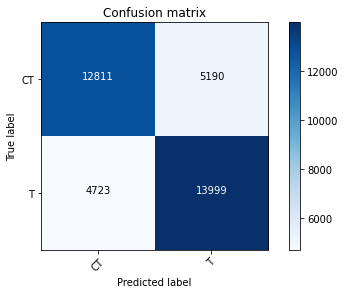

In [ ]:
y_pred = classifier.predict(X_novo_teste)
np.set_printoptions(precision=2)
confusion_matrix = metrics.confusion_matrix(y_teste, y_pred)
print(metrics.classification_report(y_teste, y_pred, target_names=['CT', 'T']))
print(metrics.confusion_matrix(y_pred=y_pred, y_true=y_teste, normalize='all'))
plot_confusion_matrix(confusion_matrix, ['CT', 'T'], False)

In [ ]:
print("Optimal number of features : %d" % seletor.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(1, len(seletor.grid_scores_) + 1),
    seletor.grid_scores_,
)
plt.axvline(x=seletor.n_features_, linewidth=1, color='r', label='line at x = {}'.format(seletor.n_features_))
plt.legend()
plt.show()